# Defining Nominal Approaches in fmdtools

Nominal simulation approaches are used to evaluate the performance of a model over a set of input parameters. It can then be used to:
- define/understand the operational envelope for different system parameters (i.e., what inputs can the system safely encounter)
- quantify failure probabilities given stochastic inputs (i.e., if the statistical distribution of inputs are known, what is the resulting probability of hazards given the design)

In [1]:
import sys
# for use in development - makes sure git version is used instead of pip-installed version
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

from fmdtools.modeldef import Model, FxnBlock
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop

The following rover model will be used to demonstrate this approach. The main task of the rover is to follow a given lane from a starting location to an ending location.

We can view the ability of the rover to track a given line with the following function:

In [2]:
import matplotlib.pyplot as plt
def plot_map(mdl, mdlhist):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_ground = mdlhist['flows']['Ground']['x']
    y_ground = mdlhist['flows']['Ground']['liney']
    plt.plot(x_ground,y_ground, label="Centerline")
    
    x_rover = mdlhist['flows']['Ground']['x']
    y_rover = mdlhist['flows']['Ground']['y']
    plt.plot(x_rover,y_rover, label = "Rover")
    
    plt.scatter(mdl.params['end'][0],mdl.params['end'][1], label="End Location")
    plt.scatter(mdlhist['flows']['Ground']['x'][-1],mdlhist['flows']['Ground']['y'][-1], label="Final Position")
    
    plt.scatter(0,0, label="Start Location")

    plt.xlabel("x-distance (meters)")
    plt.ylabel("y-distance (meters)")
    plt.title("Rover Centerline Tracking")
    plt.grid()

    plt.legend()
    
    fig = plt.figure()
    if mdl.params['linetype']=='sine':
        y_line = [sin_func(x,y_rover[i], mdl.params['amp'], mdl.params['period'])[1] for i,x in enumerate(x_rover)]
    elif mdl.params['linetype']=='turn':
        y_line = [turn_func(x,y_rover[i], mdl.params['radius'], mdl.params['start'])[1] for i,x in enumerate(x_rover)]
        
    plt.plot(x_rover, y_rover-y_line)
    plt.xlabel("x-distance (meters)")
    plt.ylabel("y-error (meters)")
    plt.title("Rover Centerline Error")

Additionally, this model has a corresponding *parameter generation* function which generates the design parameters (`params`) of the model given a reduced space of input parameters. This is the set use-case because often the *explored* set of variables is smaller than the full set. Parameter generation functions are specified in the form `method(staticargs, rangearg1=x, rangearg2=y)`, where staticargs are arguments used to define discrete cases and rangeargs are arguments used to define corresponding varied parameters. 

In this case, the static cases are 'sine' or 'turn', the type of curve being generated in the function, with the corresponding range parameters of `amplitude` and `period` (of the wave used to generate the lane), and `radius` (of the turn) and `start` (distance before/after the curve starts/ends), respectively.

In [3]:
def gen_params(linetype, **kwargs):
    if linetype == 'sine':
        amp = kwargs.pop('amp',0.2)
        wavelength=kwargs.pop('wavelength', 50)
        period = 2*np.pi/wavelength
        initangle = sin_angle_func(0, amp, period)
        lineparams = {'linetype':linetype, 'amp':amp, 'period':period, 'initangle':initangle, 'end':[wavelength,0]}
    elif linetype == 'turn':
        radius = kwargs.pop('radius',20)
        start = kwargs.pop('start', 20)
        lineparams = {'linetype':linetype, 'radius':radius, 'start':start, 'initangle':0, 'end':[radius+start,radius+start]}
    return lineparams

Below is the rest of the model setup:

In [4]:
import numpy as np
class Avionics(FxnBlock):
    def __init__(self,name, flows, params):
        self.add_params(params)
        super().__init__(name, flows, flownames={'AvionicsControl':'Control'})
        self.assoc_modes({'no_con':[1e-4, 200]}, ['drive','standby'], initmode='standby')
    def dynamic_behavior(self,time):
        if not self.in_mode('no_con'):
            if time == 5: self.set_mode('drive')
            if time == 50: self.set_mode('standby')
            
        if self.in_mode('drive'):
            self.Pos_Signal.assign(self.Video, 'angle', 'linex', 'liney')
            self.Pos_Signal.heading = self.Ground.ang 
            self.Pos_Signal.assign(self.Ground, 'x', 'y', 'vel')
            
            if in_area(self.end[0],self.end[1],1,self.Pos_Signal.x,self.Pos_Signal.y):
                self.set_mode('standby')
            elif self.Video.quality==0: self.set_mode('standby')
            else:
                ycorrection= np.arctan((self.Pos_Signal.y-self.Pos_Signal.liney)/(self.Pos_Signal.vel*np.cos(np.pi/180 * self.Pos_Signal.heading)+0.001))
                xcorrection= np.arctan((self.Pos_Signal.x-self.Pos_Signal.linex)/(self.Pos_Signal.vel*np.sin(np.pi/180 * self.Pos_Signal.heading)+0.001))
                rdiff = (self.Pos_Signal.angle - self.Pos_Signal.heading -5*(xcorrection+ycorrection))/180
                self.Control.put(rpower = 1+rdiff, lpower = 1-rdiff)
                self.Control.limit(rpower=(-1,2), lpower=(-1,2))  
        if self.in_mode('standby'):   self.Control.put(rpower = 0, lpower = 0)

class Drive(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, flownames={"EE_15":"EE_in"})
        self.assoc_modes({"mech_loss", "elec_open"})
    def dynamic_behavior(self, time):
        rpower = self.EE_in.v*self.MotorControl.rpower*self.no_fault("elec_open")/15
        lpower = self.EE_in.v*self.MotorControl.lpower*self.no_fault("elec_open")/15
        self.EE_in.a = (lpower + rpower)/12
        if (lpower + rpower) >100: self.add_fault("elec_open")
        else:
            self.Ground.vel= rpower + lpower
            self.Ground.inc(ang = 180*(rpower-lpower)/(rpower+lpower +0.001))
            self.Ground.inc(x = np.cos(np.pi/180 *self.Ground.ang) * self.Ground.vel, \
                            y = np.sin(np.pi/180 *self.Ground.ang) * self.Ground.vel)

class Perception(FxnBlock):
    def __init__(self, name, flows):
        self.set_atts(rad=1)
        super().__init__(name, flows, flownames={'EE_12':'EE'})
        self.assoc_modes({}, ['off', 'feed'], initmode='off')
    def dynamic_behavior(self,time):
        if self.in_mode('off'):
            self.EE.a=0
            self.Video.put(linex = 0,liney=0, angle = 0, quality = 0)
            if self.EE.v ==12: self.set_mode("feed")
        elif self.in_mode("feed"):
            if self.EE.v > 8:
                if in_area(self.Ground.x, self.Ground.liney, self.rad, self.Ground.x, self.Ground.y):
                    self.Video.assign(self.Ground, 'linex','liney', 'angle')
                    self.Video.quality = 1
                else:
                    self.Video.quality=0
            elif self.EE.v == 0: self.set_mode("off")
            else: self.Video.quality = 0

def in_area(x,y,rad,xc,yc):
    dist = np.sqrt((x-xc)**2+(y-yc)**2)
    return not dist > rad
    

class Power(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows, states={"charge": 100.0, 'power':0})
        self.assoc_modes({"no_charge":[1e-5, {'standby':1.0}, 100],"short":[1e-5, {'supply':1.0}, 100],}, ["supply","charge","standby","off"], initmode="off", exclusive = True, key_phases_by='self')
    def static_behavior(self,time):
        if self.in_mode("off"):     
            self.EE_5.put(v=0,a=0); self.EE_12.put(v=0,a=0);self.EE_15.put(v=0,a=0)
            if self.Control.power==1:   self.set_mode("supply")
        elif self.in_mode("supply"):
            if self.charge > 0:         self.EE_5.v = 5; self.EE_12.v = 12; self.EE_15.v = 15; 
            else:                       self.set_mode("no_charge")
            if self.Control.power==0:   self.set_mode("off")
        elif self.in_mode("short"):     self.EE_5.v = 5; self.EE_12.v = 12; self.EE_15.v = 15; 
        elif self.in_mode("no_charge"): self.EE_5.v = 0; self.EE_12.v = 0; self.EE_15.v = 0; 
        if self.in_mode("charge"):
            self.power = - 1
            if self.charge==100:self.set_mode("off")
        else:
            self.power=1+self.EE_12.mul('v','a')+self.EE_5.mul('v','a')+self.EE_15.mul('v','a')
    def dynamic_behavior(self,time):
        self.inc(charge = - self.power/100)
        self.limit(charge=(0,100))

class Override(FxnBlock):
    def __init__(self,name,flows):
        super().__init__(name,flows, flownames={'EE_5':'EE'})
        self.assoc_modes({}, ['off','standby','override'], initmode = 'off')
    def dynamic_behavior(self,time):
        if self.in_mode('off'):
            self.EE.a=0
            if self.EE.v==5: self.set_mode('standby')
        elif self.in_mode('standby'):
            self.MotorControl.assign(self.AvionicsControl, 'rpower','lpower')
            if self.OverrideComms =='active' and self.EE.v>4: self.set_mode('override')
        elif self.in_mode('override'):
            self.MotorControl.assign(self.OverrideComms, 'rpower', 'lpower')
   
class Communications(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows)
    def dynamic_behavior(self,time):
        if self.EE_12.v == 12:
            self.EE_12.a=1
            self.Comms.assign(self.Pos_Signal, 'x', 'y', 'vel', 'heading')
        else:   self.Comms.put(x=0, y=0, vel=0, heading=0)

class Operator(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows)
    def dynamic_behavior(self, t):
        if t==1:    self.Control.power=1
        elif t==55: self.Control.power=0

class Environment(FxnBlock):
    def __init__(self, name, flows,params):
        self.add_params(params)
        super().__init__(name,flows)
    def dynamic_behavior(self, t):
        if self.linetype=='sine':
            self.Ground.angle = sin_angle_func(self.Ground.x, self.amp, self.period)
            self.Ground.linex,self.Ground.liney = sin_func(self.Ground.x,self.Ground.y, self.amp, self.period)
        elif self.linetype=='turn':
            self.Ground.angle = turn_angle_func(self.Ground.x, self.radius, self.start)
            self.Ground.linex, self.Ground.liney = turn_func(self.Ground.x, self.Ground.y, self.radius, self.start)

def sin_func(x,y, amp, period):
    return x, amp * np.sin(period*x)
def sin_angle_func(x, amp, period):
    return amp * period * np.cos(period*x)*180/np.pi

def turn_func(x,y, radius,start):
    if   x >= start+radius: return start+radius, y
    elif y >= radius:       return start+radius, y
    elif x >= start:        return x, radius - np.sqrt(radius**2 - (x-start)**2)
    elif x < start:         return x, 0
def turn_angle_func(x, radius, start):
    if   x >= start+radius: return 90.0
    elif x >= start:        return 90 - np.arccos(((x-start)/radius))*180/np.pi  #np.arctan((x-start)/(radius**2-(start-x)**2))*180/np.pi
    elif x<start:           return 0.0

class Rover(Model):
    def __init__(self, params=gen_params('turn'),\
                 modelparams={'times':[0,60], 'tstep':1, 'phases':{'start':[1,30], 'end':[31, 60]}},\
                     valparams={}):
        super().__init__(params, modelparams, valparams)
        
        self.add_flow('Ground', {'x':0.0,'y':0.0,'liney':0.0,'linex':0.0, 'vel':0.0, 'line':0.0, 'angle':params['initangle'], 'ang':0.0})
        self.add_flow('Pos_Signal', {'x':0.0,'y':0.0,'liney':0.0,'linex':0.0, 'heading':0.0, 'vel':0.0, 'line':0, 'angle':0.0})
        self.add_flow('EE_12', {'v':0.0, 'a':0.0})
        self.add_flow('EE_5', {'v':0.0, 'a':0.0})
        self.add_flow('EE_15', {'v':0.0, 'a':0.0})
        self.add_flow('Video', {'liney':0.0,'linex':0.0, 'angle':params['initangle'], 'quality':1})
        self.add_flow('AvionicsControl', {'rpower':0.0, 'lpower':0.0})
        self.add_flow('MotorControl', {'rpower':0.0, 'lpower':0.0})
        self.add_flow('Control', {'power':0.0})
        self.add_flow('Comms', {'x':0.0,'y':0.0, 'vel':0.0, 'heading':0.0})
        self.add_flow('OverrideComms', {'rpower':0.0, 'lpower':0.0, 'active':0} ) 
        #self.add_flow('Example_Disconnect')
        
        self.add_fxn("Power", ["EE_15","EE_5",'EE_12', "Control"], Power)
        self.add_fxn("Operator", ["Comms", "OverrideComms", "Pos_Signal", "Control"], Operator)
        self.add_fxn("Communications", ["Comms", "EE_12", 'Pos_Signal'], Communications)
        self.add_fxn("Perception", ["Ground", "EE_12", "Video"], Perception)
        self.add_fxn("Avionics",["Video","Comms", "EE_5",'Pos_Signal',"Ground", "AvionicsControl"], fclass=Avionics, fparams=params)
        self.add_fxn("Override", ["OverrideComms", "EE_5", 'MotorControl','AvionicsControl'], Override)
        self.add_fxn("Drive", ["Ground","EE_15","EE_5", "MotorControl"], fclass = Drive)
        self.add_fxn("Environment", ['Ground'], Environment, fparams = params)
        
        pos_bip = {'Power': [-0.684772948203272, -0.2551613615446115],
                 'Operator': [-0.798933011500376, 0.565156755693186],
                 'Communications': [-0.5566050878414673, 0.14159180700630447],
                 'Perception': [0.996672509613648, 0.2507215448302319],
                 'Avionics': [0.28027473355741117, 0.47255264233968597],
                 'Override': [0.28987624783062627, -0.17144760874154652],
                 'Drive': [0.6671719569482308, -0.571646956655247],
                 'Environment': [1.1329643169383754, -0.6375225566564033],
                 'Ground': [1.108432946123935, -0.3228541151507237],
                 'Pos_Signal': [-0.256557435572734, 0.5411037985681082],
                 'EE_12': [-0.3676879520509888, -0.04754907961317867],
                 'EE_5': [-0.2181352416728437, -0.2015320865756482],
                 'EE_15': [-0.5352906801304353, -0.5288715575154177],
                 'Video': [0.6726175830840695, 0.396008366729458],
                 'AvionicsControl': [0.45997843863482324, 0.04522869632581994],
                 'MotorControl': [0.6350063940085445, -0.3013633829278297],
                 'Control': [-0.9857988678463686, 0.07960895587242012],
                 'Comms': [-0.642370284813957, 0.35285736707043763],
                 'OverrideComms': [-0.14607433032593392, 0.2981956996230818]}
        
        self.build_model(bipartite_pos = pos_bip)
    def find_classification(self,scen,mdlhist):
        modes, modeproperties = self.return_faultmodes()
        classification = str()
        if not in_area(self.flows['Ground'].x,self.flows['Ground'].y,1,self.params['end'][0],self.params['end'][1]):
                                classification = "incomplete mission"
        if any(modes):          classification = classification +' faulty'
        if not classification:  classification = 'nominal mission'
        return {'rate':0,'cost':0, 'prob':scen['properties'].get('prob',1), 'expected cost':0, 'faults':modes, 'classification':classification}

Below shows the performance of the rover during a (default) turn with a radius of 20 meters that begins at 20 meters. As shown, there is a significant amount of drift, but not enough for the rover to get lost (that would take 1 meter of drift).

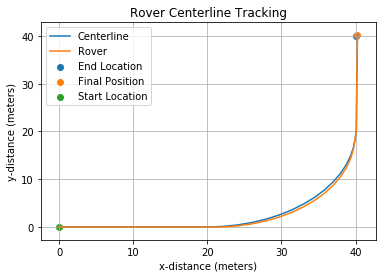

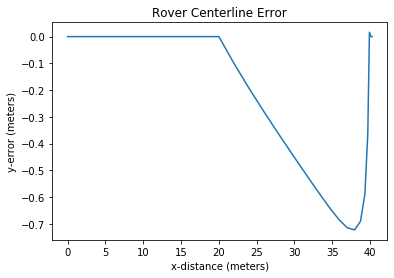

In [5]:
mdl = Rover(params=gen_params('turn'))
endresults, resgraph, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

Below shows the performance of the model over a sine wave. As shown, the drift is much smaller because the turns are much less pronounced (a movement of 0.2 meters over 25 meters). 

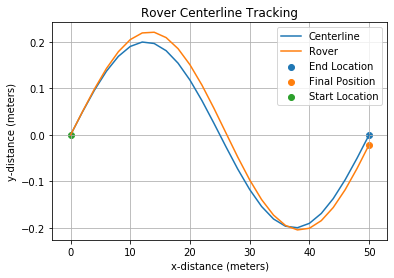

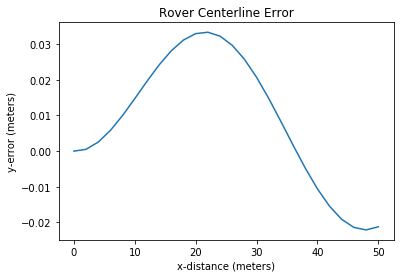

In [6]:
mdl = Rover(params=gen_params('sine'))
endresults, resgraph, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

The performance of the rover in these situations is dependent on the parameters of the situation (e.g., the radius of the curve and the amplitude of the sine wave). Thus, it is important to define the operational envelope for the system. This can be done using a `NominalApproach`, which can be used to define ranges of variables to simulate the system under.

In [7]:
from fmdtools.modeldef import NominalApproach

In [8]:
help(NominalApproach)

Help on class NominalApproach in module fmdtools.modeldef:

class NominalApproach(builtins.object)
 |  Class for defining sets of nominal simulations. To explain, a given system 
 |  may have a number of input situations (missions, terrain, etc) which the 
 |  user may want to simulate to ensure the system operates as desired. This 
 |  class (in conjunction with propagate.nominal_approach()) can be used to 
 |  perform these simulations.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_param_ranges(self, paramfunc, rangeid, *fixedargs, **inputranges)
 |      Adds a set of scenarios to the approach.
 |      
 |      Parameters
 |      ----------
 |      paramfunc : method
 |          Python method which generates a set of model parameters given the input arguments.
 |          method should have form: method(fixedarg, fixedarg..., inputarg=X, inputarg=X)
 |      rangeid : str
 |          Name for 

In this approach we define parameter ranges for the two major situations--a wavelength and amplitude for the sine wave, and a radius and start location for the turn.

Defining an approach in terms of ranges is performed with `.add_param_ranges()`

In [9]:
app = NominalApproach()
help(app.add_param_ranges)

Help on method add_param_ranges in module fmdtools.modeldef:

add_param_ranges(paramfunc, rangeid, *fixedargs, **inputranges) method of fmdtools.modeldef.NominalApproach instance
    Adds a set of scenarios to the approach.
    
    Parameters
    ----------
    paramfunc : method
        Python method which generates a set of model parameters given the input arguments.
        method should have form: method(fixedarg, fixedarg..., inputarg=X, inputarg=X)
    rangeid : str
        Name for the range being used. Default is 'nominal'
    *fixedargs : any
        Fixed positional arguments in the parameter generator function. 
        Useful for discrete modes with different parameters.
    **inputranges : key=tuple
        Ranges for each input argument to be iterated over specified as input = (start, end, step)
        (note that end is not inclusive)



In [10]:
app.add_param_ranges(gen_params,'sine','sine', amp=(0, 10, 0.2), wavelength=(10,50,10))
app.add_param_ranges(gen_params,'turn','turn', radius=(5,40,5), start=(0, 20,5))

Notice that `gen_params` is the handle of the method defined earlier to generate the nominal parameters of the model, `sine` is a fixed parameter defining a discrete case of scenarios, and `amp` and `wavelenth` are parameters that are varied (the given tuples define the respective ranges).

The result is a defined set of scenarios which can be run in the model:

In [11]:
app.scenarios

{'sine_1': {'faults': {},
  'properties': {'type': 'nominal',
   'time': 0.0,
   'name': 'sine_1',
   'params': {'linetype': 'sine',
    'amp': 0.0,
    'period': 0.6283185307179586,
    'initangle': 0.0,
    'end': [10, 0]},
   'inputparams': {'amp': 0.0, 'wavelength': 10},
   'paramfunc': <function __main__.gen_params(linetype, **kwargs)>,
   'fixedargs': ('sine',),
   'prob': 0.005}},
 'sine_2': {'faults': {},
  'properties': {'type': 'nominal',
   'time': 0.0,
   'name': 'sine_2',
   'params': {'linetype': 'sine',
    'amp': 0.0,
    'period': 0.3141592653589793,
    'initangle': 0.0,
    'end': [20, 0]},
   'inputparams': {'amp': 0.0, 'wavelength': 20},
   'paramfunc': <function __main__.gen_params(linetype, **kwargs)>,
   'fixedargs': ('sine',),
   'prob': 0.005}},
 'sine_3': {'faults': {},
  'properties': {'type': 'nominal',
   'time': 0.0,
   'name': 'sine_3',
   'params': {'linetype': 'sine',
    'amp': 0.0,
    'period': 0.20943951023931953,
    'initangle': 0.0,
    'end': [

Nominal Approaches are simulated using `prop.nominal_approach`.

In [12]:
help(prop.nominal_approach)

Help on function nominal_approach in module fmdtools.faultsim.propagate:

nominal_approach(mdl, nomapp, track='all', showprogress=True, pool=False)
    Simulates a set of nominal scenarios through a model. Useful to understand
    the sets of parameters where the system will run nominally and/or lead to 
    a fault.
    
    Parameters
    ----------
    mdl : Model
        Model to simulate
    nomapp : NominalApproach
        Nominal Approach defining the nominal scenarios to run the system over.
    track : str, optional
        States to track during simulation. The default is 'all'.
    showprogress : bool, optional
        Whether to display progress during simulation. The default is True.
    pool : Pool, optional
        Parallel pool (e.g. multiprocessing.Pool) to simulate with 
        (if using parallelism). The default is False.
    
    Returns
    -------
    endclasses : Dict
        Classifications of the set of scenarios, with structure {'name':classification}
    mdl

In [13]:
endclasses, mdlhists= prop.nominal_approach(mdl, app)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████| 228/228 [00:02<00:00, 110.05it/s]


To speed up execution over large numbers of scenarios, multiprocessing can also be used to run the scenarios in parallel.

In [14]:
import multiprocessing as mp

In [ ]:
if __name__=="__main__":
    endclasses, mdlhists= prop.nominal_approach(mdl, app, pool = mp.Pool(5))

SCENARIOS COMPLETE:   0%|                                                                      | 0/228 [00:00<?, ?it/s]